In [1]:
import numpy as np
from scipy import linalg
from scipy.integrate import solve_bvp
from scipy.optimize import curve_fit, root, fsolve, minimize_scalar, root_scalar

from scipy.interpolate import interp1d

from scipy.special import zeta

from joblib import Parallel, delayed

from tqdm import tqdm
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 35,
    "text.latex.preamble": r"\usepackage{color}",
})
plt.rcParams["figure.figsize"] = (7, 7)

In [2]:
# T_{c0} = 3.8\ K,\qquad \xi = 10\times 10^{-9}\ m\to 	
# \mathcal{A}_H = \frac{g\mu_B H_{c2}}{\pi T_{c0}} \to 
# \frac{ 1 \times  \times  \frac{\times}{2\times  \times ()^2}}{3.14 \times 3.8\ K \times} = 
#

gLande = 2.
muB = 9.3*1e-21 # \frac{erg}{G}
hbar = 1e-27 # erg\times s
c = 3e10 # cm/s
e0 = 4.8*1e-10 # statC
xi0 = 100*1e-10*1e2 # cm
Tc0 = 3.8 # K
kB =  1.4e-16 # \frac{erg}{K}
Hc2 = hbar*c/(2.*e0*xi0**2)
print(" Hc2 = ", Hc2, "G = ", Hc2/1e4, "T")
A_H = np.float64(gLande * muB * Hc2 / (np.pi * kB * Tc0))
print(" A_H = ", A_H)

sigmaD = 9e15 # s^{-1}
j_s0 = sigmaD * 3.14 * kB * Tc0 / (e0 * xi0)
print(" j_s0 = ", j_s0,"statC/s = ", j_s0*1e4/(3e9),"A/m^2")

mathcalB = c * Hc2 / (4 * 3.14 * j_s0 * xi0)
print(" mathcalB = ", mathcalB)

 Hc2 =  31250.0 G =  3.125 T
 A_H =  0.3477774837299405
 j_s0 =  3.13215e+16 statC/s =  104405000000.00002 A/m^2
 mathcalB =  2383.0825389979063


In [3]:
def _gauss_series_weights(n):
    r"""
    Compute Gauss quadrature weights for an infinite series.

    .. math::

       \sum_{j=1}^\infty f(j) \simeq \sum_{k=1}^n w_k f(x_k)

    Uses the method in [1]_.

    Parameters
    ----------
    n : int
        Number of quadrature points to return.

    Returns
    -------

    References
    ----------
    .. [1] H. Monien, "Gaussian quadrature for sums: a rapidly
       convergent summation scheme", Math. Comp. 79, 857 (2010).
       doi:10.1090/S0025-5718-09-02289-3

    """
    if n <= 0:
        raise ValueError("n must be positive")
    elif n == 1:
        return np.array([1.0]), np.array([1.0])

    j = np.arange(n)
    j1 = j[1:]

    # Method in [1]: gauss quadrature weights for
    #
    #    sum_{k=1}^oo 1/k^2 f(1/k^2)
    #
    # The abscissas are zeros of `p_n(lmb)` where:
    #
    # lmb = 1/x**2
    # p_n = lambda n, lmb: bessel_poly_yn(2*n+1, -1j*np.sqrt(lmb)/np.pi).real
    # bessel_poly_yn = lambda n, x: np.sqrt(2/(np.pi*x)) * np.exp(1/x) * special.kv(n+0.5, 1/x)

    # Recurrence formula from [1]
    a = 2 * np.pi**2 / (4 * j + 1) / (4 * j + 5)
    a[0] = np.pi**2 / 15
    sqrt_b = np.pi**2 / np.sqrt((4 * j1 - 1) * (4 * j1 + 3)) / (4 * j1 + 1)

    m0 = np.pi**2 / 6  # = sum_{k=1}^oo 1/k^2

    # Compute eigenvalues and first elements of eigenvectors
    #
    # What follows is equivalent to::
    #
    #     z, w = linalg.eigh_tridiagonal(a, sqrt_b)
    #     w = w[0,:]
    #
    # but uses less memory (we only need the first element of each
    # eigenvector).

    m, z, iblock, isplit, info = linalg.lapack.dstebz(a, sqrt_b, 0, 0, 0, 0, 0, 0, "B")
    if info != 0:
        raise ValueError("dstebz failed")

    block_size = max(10, 6250000 // n)

    w = np.empty_like(z)
    iblock2 = np.empty(n, dtype=int)
    for k in range(0, n, block_size):
        zb = z[k : k + block_size]
        iblock2[: len(zb)] = iblock[k : k + block_size]
        wb, info = linalg.lapack.dstein(a, sqrt_b, zb, iblock2, isplit)
        if info != 0:
            raise ValueError("dstein failed at k={}".format(k))
        w[k : k + block_size] = wb[0, :]

    # Then find eigenvectors, one by one

    # Convert back to unweighted sum (z = 1/x^2)
    w = m0 * w**2 / z
    x = z ** (-0.5)

    # Swap order
    x = x[::-1]
    w = w[::-1]

    x.flags.writeable = False
    w.flags.writeable = False

    return x, w

def get_matsubara_sum(T, E_typical=1.0, max_ne=2000, steps=1):
    r"""
    Get Matsubara sum/quadrature.

    Gives the approximation:

    .. math::

       T \sum_{n=-\infty}^\infty f(\omega_n) \simeq \sum_{j=0}^{M-1} a_j f(w_j)

    where :math:`f(\omega)` is an analytic function decaying sufficiently
    fast at :math:`\omega\to\pm\infty`.

    The quadrature applies the method of [1]_, which is based on applying
    the idea of Gaussian quadrature to infinite summation of polynomials
    in :math:`z = n^{-2}`.

    Parameters
    ----------
    T : float
        Temperature
    E_typical : float
        Expected typical energy scale of the summand
    max_ne : int
        Max number of frequencies in summation

    Returns
    -------
    w : ndarray
        Energies to evaluate at
    a : ndarray
        Quadrature weights

    Examples
    --------
    >>> import numpy as np
    >>> from usadelndsoc.matsubara import get_matsubara_sum
    >>> w, a = get_matsubara_sum(T=1, E_typical=1)
    >>> n = w / (2*np.pi) + 0.5; n
    array([-55.01190294, -17.89542335, -10.6225115 ,  -7.63686822,
            -6.07573899,  -5.00201745,  -4.00000629,  -3.        ,
            -2.        ,  -1.        ,   0.        ,   1.        ,
             2.        ,   3.        ,   4.        ,   5.00000629,
             6.00201745,   7.07573899,   8.63686822,  11.6225115 ,
            18.89542335,  56.01190294])
    >>> (a * 1/w**2).sum(), 1/4
    (0.25000271006449587, 0.25)

    The above Gaussian quadrature based sum converges much faster
    than the naive one:

    >>> w_naive = 2*np.pi*(np.arange(-60, 60) + 0.5)
    >>> (1/w_naive**2).sum()
    0.24915567634606217

    The quadrature is exact for :math:`\sum_{n=1}^\infty p(n^{-2})`
    where `p` is a polynomial up to high order:

    >>> a = a[n>0]; n = n[n>0]
    >>> (a * (1/n**2 + 2/n**4 + 4/n**16)).sum()
    7.809641663308138
    >>> import sympy; m = sympy.symbols('m')
    >>> r = sympy.Sum(1/m**2 + 2/m**4 + 4/m**16, (m, 1, sympy.oo)).doit()
    >>> r
    pi**2/6 + pi**4/45 + 7234*pi**16/162820783125
    >>> r.n()
    7.80964166330814

    References
    ----------
    .. [1] H. Monien, "Gaussian quadrature for sums: a rapidly
       convergent summation scheme", Math. Comp. 79, 857 (2010).
       doi:10.1090/S0025-5718-09-02289-3

    """

    E_max = 1000 * abs(E_typical)
    try:
        ne = 5 + int(np.sqrt(4 * E_max / (np.pi**2 * abs(T))))
        k, rem = divmod(ne, steps)
        if rem != 0:
            k += 1
        ne = k * steps
    except (ZeroDivisionError, OverflowError):
        ne = np.inf

    if not (ne < max_ne):
        raise ValueError("Too many matsubara frequencies required")

    # Get weights for sum_{n=1}^oo f(n) =~ sum(weights * f(x))
    x, weights = _gauss_series_weights(ne)

    E = 2 * np.pi * T * (x - 0.5)
    #weights = weights * T

    assert E[-1] >= E_max

    # Get two-tailed
    E = np.r_[-E[::-1], E]
    weights = np.r_[weights[::-1], weights]

    k = int(E.size/2)
    return E[k:], weights[k:]



In [13]:
class S_I_bilayer:

    def Get_Delta_s_In_pi_Tc(self, t):
        result_prev = 0.
        result = 2.
        if (t > 1.0):
            return 0.
        while (np.abs(result - result_prev) >= self.eps_t):
            result_prev = result
            S_prev = 0
            S = 0
            S1_prev = 0
            S1 = 0
            i = 0
            # all the sums over \omega_n here are convergent
            # thus, we evaluate them until the precision eps_t/1e3 is reached
            while True:
                S_prev = S
                S1_prev = S1
                S = S + 1./(2*i+1) - t/np.sqrt(result**2 + t**2*(2*i+1)**2)
                S1 = S1 + 1./np.power(result**2 + t**2*(2*i+1)**2, 1.5)
                i = i + 1
                if  np.sqrt((S - S_prev)**2 + (S1 - S1_prev)**2) <= self.eps_t/1e3:
                    break
                p = (2*S + np.log(t))/(2*S + np.log(t) + t*result**2**2*S1)
            result = result* 2*S1*t*result**2/(2*S + np.log(t) + 2*S1*t*result**2)  
        return result # it returtns Delta_s/(\pi T_c0)

    def Get_tildeW(self, t):
        Delta = self.Get_Delta_s_In_pi_Tc(t)
        return (0.5*np.pi*Delta)*np.tanh(np.pi*Delta/(2*t))

    def H_z(self, z, p):
        # p = [d_S, theta_I, H0, n_Matsubara, t, Delta, p_S0, tildeGamma]
        # p_S0 = (tildeI - tildeJ)/(d_S*tildeW)
        H0 = p[2]
        return H0
    
    def P_S_z(self, z, p):
        # p = [d_S, theta_I, H0, n_Matsubara, t, Delta, p_S0, tildeGamma]
        # p_S0 = (tildeI - tildeJ)/(d_S*tildeW)
        d_S = p[0]
        H0 = p[2]
        p_S0 = p[6]
        return - H0*(z - d_S/2.) + p_S0
            

    def theta_zeta_solutions(self, p):
        # Y = [theta_re, theta_im, theta'_re, theta'_im, zeta_re, zeta_im, zeta'_re, zeta'_im]
        # p = [d_S, theta_I, H0, n_Matsubara, t, Delta, p_S0, tildeGamma]
        # p_S0 = (tildeI - tildeJ)/(d_S*tildeW)
        H0 = p[2]
        n_Matsubara = p[3]
        t = p[4]
        omega_n = t*(2. * n_Matsubara + 1.)
        Delta = p[5]
        p_S0 = p[6]
        def Foo(d_S, theta_I, tildeGamma, p_S, H0, omega_n, Delta, X):
            # X = [theta_re, theta_im, zeta_re, zeta_im]
            theta = X[0] + 1j*X[1]
            zeta = X[2] + 1j*X[3]
            X = p_S**2 + d_S**2*H0**2/12
            p_S1 = H0*d_S/2 + p_S
            I1 = 1j*theta_I*p_S1*np.sinh(zeta)*np.cosh(zeta)**2*np.cosh(theta)/d_S -0.5*X*np.cosh(2*zeta)*np.sinh(2*theta) - \
                        omega_n*np.cosh(zeta)*np.sinh(theta) - 1j*np.cosh(theta)*(Delta*np.cosh(zeta) + A_H*H0*np.sinh(zeta))
            I2 = 1j*theta_I*p_S1*(np.cosh(zeta) + 3*np.cosh(3*zeta))*np.sinh(theta)/(4*d_S) - 2*tildeGamma*np.sinh(2*zeta)/d_S  - \
                        0.5*X*np.sinh(2*zeta)*np.cosh(2*theta) - \
                        omega_n*np.sinh(zeta)*np.cosh(theta) - 1j*np.sinh(theta)*(Delta*np.sinh(zeta) + A_H*H0*np.cosh(zeta))
            return np.array([np.real(I1), np.imag(I1), np.real(I2), np.imag(I2)])

        theta0 = np.arctanh(-1j*Delta/omega_n)
        zeta0 = 0
        d_S = p[0]
        theta_I = p[1]
        tildeGamma = p[7]
        R = root(lambda X: Foo(d_S, theta_I, tildeGamma, p_S0, H0, omega_n, Delta, X), 
                 np.array([np.real(theta0), np.imag(theta0), np.real(zeta0), np.imag(zeta0)]), 
                 method="krylov", tol=self.eps_t, options={"maxiter":200})
        if not R.success:
            print("----> theta zeta solutuin problem: ", R.message, " p = ", p)
        theta0 = R.x[0] + 1j*R.x[1]
        zeta0 = R.x[2] + 1j*R.x[3]

        #norm = np.linalg.norm(Foo(d_S, theta_I, tildeGamma, p_S0, H0, omega_n, Delta, 
        #            np.array([np.real(theta0), np.imag(theta0), np.real(zeta0), np.imag(zeta0)])))

        #if (norm >= self.eps_t):
        #    print("-----> ! theta_0 = ", theta0, 
        #          " zeta0 = ", zeta0, 
        #          " |Foo(theta0, zeta0)| = ", norm)
        #    print("-----> p = ", p)
        
        return theta0, zeta0

    def Solve_Usadel_at_omega_n(self, p):
        # Y = [theta_re, theta_im, theta'_re, theta'_im, zeta_re, zeta_im, zeta'_re, zeta'_im]
        # p = [d_S, theta_I, H0, n_Matsubara, t, Delta, p_S0, tildeGamma]
        # p_S0 = (tildeI - tildeJ)/(d_S*tildeW)
        theta_I = p[1]
        n_Matsubara = p[3]
        t = p[4]
        Delta = p[5]
        theta0, zeta0 = self.theta_zeta_solutions(p)    
        theta = theta0
        zeta = zeta0
        theta1 = theta0
        zeta1 = zeta0 
        fs_averaged = np.cosh(zeta)*np.sinh(theta) 


        omega_n = t*(2*n_Matsubara + 1)
        Q = p[6] 
        H0 = p[2]
        d_S = p[0]
        t = p[4]
        #X = Q**2 + H0**2*d_S**2/12/t
        #fs_theor = - 1j*Delta*(omega_n  + X)/( (omega_n + X)**2 + ((A_H - c.theta_I/2)*H0 - c.theta_I*Q/c.d_S)**2 )
        #print(" fs_averaged = ", fs_averaged, " fs_theor = ", fs_theor)
        #print("  ", np.abs(fs_averaged - fs_theor)/np.abs(fs_averaged))
        
        delta_Delta = 2*(Delta/(2*n_Matsubara + 1) + t*np.imag(fs_averaged))
        #delta_tildeW = np.real( -t*(np.cosh(2*zeta)*np.cosh(2*theta) - 1)) 
        #delta_tildeJ = -np.imag(- (t*2*theta_I)*np.sinh(zeta1)*np.cosh(zeta1)**2*np.sinh(theta1))
        return  delta_Delta, theta, zeta

    def Sum_for_Delta_W_J(self, X, d_S, theta_I, H0, t, tildeGamma, p_S0):
        Delta = X[0]
        S = 0.
        W, A = get_matsubara_sum(T=t, E_typical=t)
        W = np.flip(W)
        A = np.flip(A)
        i = 0
        Delta_S = 0.
        while i < len(W):
            w = W[i]
            a = A[i]
            p = [d_S, theta_I, H0,  (w/(np.pi*t) - 1.)/2., t, Delta, p_S0, tildeGamma]
            Delta_S, theta, zeta = self.Solve_Usadel_at_omega_n(p)
            S = S + a*Delta_S          
            S_prev = S
            i = i + 1
        S = S + np.log(t)*Delta
        if np.isclose(S, 0):
            S = 0.
        return S

    def Get_state_root(self, d_S, theta_I, tildeGamma, p_S0, H0, t, Delta0=0., tildeW0=0., tildeJ0=0.):
        # p = [d_S, theta_I, H0, n_Matsubara, t, Delta, p_S0, tildeGamma]
        if np.isclose(Delta0, 0):
            Delta0 = self.Get_Delta_s_In_pi_Tc(t)
            tildeW0 = self.Get_tildeW(t)
            tildeJ0 = 0.
        Foo = lambda X: self.Sum_for_Delta_W_J(X, d_S, theta_I, H0, t, tildeGamma, p_S0)

        #R = minimize_scalar(Foo, 
        #              #   bounds=[0., 1.],
        #                 method="brent",
        #                 options={"xatol": self.eps_t})
        #Delta = R.x

        def keep_first_occurrences(arr, atol=1e-4):
            seen = []
            result = []
            for val in arr:
                # Check if value is close to any already seen values
                if not any(np.isclose(val, seen_val, atol=atol) for seen_val in seen):
                    result.append(val)
                    seen.append(val)
            return np.array(result)

        #zero_guesses = np.linspace(0., self.Get_Delta_s_In_pi_Tc(t), num=10)
        zero_guesses = np.array([0., Delta0])
        solutions = np.array([])
        for Delta0 in zero_guesses: 
            R = root(Foo, [Delta0], method="krylov", tol=self.eps_t)
            Delta_r = R.x[0]
            if not R.success:
                print("\n---------> Get_state_root root:", R.message)
                print("---------> d_S = ", d_S, " theta_I = ", theta_I, " H0 = ", H0," t = ", t, " tildeGamma = ", tildeGamma, " p_S0 = ", p_S0, "\n")
            elif np.linalg.norm(Foo([Delta_r])) >= self.eps_t and R.success:
                print("\n---------> Get_state_root problem: Delta = ", Delta_r, "|S| = ", np.linalg.norm(Foo([Delta_r])) )
                print("---------> d_S = ", d_S, " theta_I = ", theta_I, " H0 = ", H0," t = ", t, " tildeGamma = ", tildeGamma, " p_S0 = ", p_S0, "\n")
            else:
                solutions = np.append(solutions, Delta_r)
        

        #print("----> d_S = ", d_S, " theta_I = ", theta_I, " H0 = ", H0," t = ", t, " tildeGamma = ", tildeGamma, " p_S0 = ", p_S0)
        #print("----> solutions = ", solutions, "\n")

        # print(solutions)
        solutions = np.delete(solutions, np.where(solutions < 0.))
        solutions = keep_first_occurrences(solutions)
        solutions = np.delete(solutions, 0)

        if len(solutions) == 0:
            Delta = 0.
        elif len(solutions) != 1:
            print("----> d_S = ", d_S, " theta_I = ", theta_I, " H0 = ", H0," t = ", t, " tildeGamma = ", tildeGamma, " p_S0 = ", p_S0)
            print("----> solutions = ", solutions, "\n")
        else:
            Delta = solutions[0]
        
        #print(" F(a) = ", Foo(-1), " Foo(b) = ", Foo(1))
        #print("---------> d_S = ", d_S, " theta_I = ", theta_I, " H0 = ", H0," t = ", t, " tildeGamma = ", tildeGamma, " p_S0 = ", p_S0)
        #R = root_scalar(Foo, x0=[Delta0], method="newton")
        #Delta = R.root[0]
        #if not R.converged :
        #    print("---------> Get_state_root root_scalar: ", R.flag)
        #    print("--------->  d_S = ", d_S, ", theta_I = ", 
        #          theta_I, ", tildeGamma = ", tildeGamma, ", p_S0 = ", p_S0, ", H0 = ", H0, ", t = ", t, "\n")
        
        W, A = get_matsubara_sum(T=t, E_typical=t)
        W = np.flip(W)
        A = np.flip(A)
        i = 0
        tildeW = 0.
        tildeJ = 0.
        while i < len(W):
            w = W[i]
            a = A[i]
            p = [d_S, theta_I, H0,  (w/(np.pi*t) - 1.)/2., t, Delta, p_S0, tildeGamma]
            Delta_S, theta, zeta = self.Solve_Usadel_at_omega_n(p)
            i = i + 1
            theta1 = theta
            zeta1 = zeta
            tildeW = tildeW + a*np.real(-t*(np.cosh(2*zeta)*np.cosh(2*theta) - 1) )
            tildeJ = tildeJ + a*np.imag(- (t*2*theta_I)*np.sinh(zeta1)*np.cosh(zeta1)**2*np.sinh(theta1))
        return np.array([Delta, tildeW, tildeJ])


    def pS_characteristics(self, H0, t, p_S_step=1e-2, p_S_min=-0.05, p_S_max=0.05, to_disk=True, verbose=False):
        # p_S0 = (tildeI - tildeJ)/(d_S*tildeW)
        p_S_data = np.array([])
        data_tildeW = np.array([])
        data_Delta = np.array([])
        data_tildeI = np.array([])
        data_tildeJ = np.array([])

        Delta = self.Get_Delta_s_In_pi_Tc(t)
        p_S0 = 0.
        while p_S0 < p_S_max:
            Delta, tildeW, tildeJ = self.Get_state_root(self.d_S, self.theta_I, self.tildeGamma, p_S0, H0, t, Delta0=Delta)
            if (np.isclose(p_S0, 0.) and Delta < 1e-4):
            	print("---> Wrong initial condition for Delta: ", self.d_S, self.theta_I, self.tildeGamma, p_S0, H0, t)
            tildeI = tildeJ + tildeW * self.d_S * p_S0
            if verbose:
                print("""--> : p_S = {:.3e}, Delta = {:.3e}, tildeW = {:.3e}, 
                        tildeJ = {:.3e}, tildeI = {:.3e},""".format(p_S0, Delta, tildeW, tildeJ, tildeI))
            data_tildeW = np.append(data_tildeW, tildeW)
            data_Delta = np.append(data_Delta, Delta)
            data_tildeJ = np.append(data_tildeJ, tildeJ)
            data_tildeI = np.append(data_tildeI, tildeI)
            p_S_data = np.append(p_S_data, p_S0)
            p_S0 = p_S0 + p_S_step
            if Delta < 1e-4:
            	break

        Delta = self.Get_Delta_s_In_pi_Tc(t)
        p_S0 = 0.
        while p_S0 > p_S_min:
            Delta, tildeW, tildeJ = self.Get_state_root(self.d_S, self.theta_I, self.tildeGamma, p_S0, H0, t, Delta0=Delta)
            if (np.isclose(p_S0, 0.) and Delta < 1e-4):
            	print("---> Wrong initial condition for Delta: ", self.d_S, self.theta_I, self.tildeGamma, p_S0, H0, t)
            tildeI = tildeJ + tildeW * self.d_S * p_S0
            if verbose:
                print("""--> : p_S = {:.3e}, Delta = {:.3e}, tildeW = {:.3e}, 
                        tildeJ = {:.3e}, tildeI = {:.3e},""".format(p_S0, Delta, tildeW, tildeJ, tildeI))
            data_tildeW = np.append(data_tildeW, tildeW)
            data_Delta = np.append(data_Delta, Delta)
            data_tildeJ = np.append(data_tildeJ, tildeJ)
            data_tildeI = np.append(data_tildeI, tildeI)
            p_S_data = np.append(p_S_data, p_S0)
            p_S0 = p_S0 - p_S_step
            if Delta < 1e-4:
            	break

        if not to_disk:
            return [p_S_data, data_Delta, data_tildeI, data_tildeJ, data_tildeW]
                
        fname = "I_S_p_S_d_S={}_theta_I={}_t={}_H0={}".format(round(self.d_S, 5), round(self.theta_I, 5), round(t, 5), round(H0, 5))
        sdata = "# I_S on p_S0 dependence for d_S = {}, theta_I = {} \n".format(self.d_S, self.theta_I)
        sdata = sdata + "# t = {}, H_0 = {} \n".format(t, H0)
        sdata = sdata  + "# p_S tildeI Delta tildeW tildeJ \n"
        fname = fname.replace(".","-")
        fname = fname + ".dat"
        file = open(fname, "w")
        file.write(sdata)
        for i in range(len(p_S_data)):
            file.write("{} {} {} {} {} \n".format(p_S_data[i], data_tildeI[i], data_Delta[i], data_tildeW[i], data_tildeJ[i]))
        file.close()
        
        return [p_S_data, data_Delta, data_tildeI, data_tildeJ, data_tildeW]

    def Get_state_at_fixed_current(self, H0, t, tildeI0=0., p_S_step=1e-2, p_S_min=-0.05, p_S_max=0.05, verbose=False):
        data = self.pS_characteristics(H0, t, p_S_step=p_S_step, p_S_min=p_S_min, p_S_max=p_S_max)
    
        tildeDeltas = interp1d(data[0], data[1], bounds_error=True, kind='linear')
        tildeIs = interp1d(data[0], data[2], bounds_error=True, kind='linear')
        tildeJs = interp1d(data[0], data[3], bounds_error=True, kind='linear')
        tildeWs = interp1d(data[0], data[4], bounds_error=True, kind='linear')

        if np.isclose(np.min(data[0]), np.max(data[0])):
            return np.array([0, 0, 0])

        k = np.argmin(data[2])
        j = np.argmax(data[2])
        bounds = (np.min([data[0][k], data[0][j]]), np.max([data[0][k], data[0][j]]))
        res = minimize_scalar(lambda x: np.abs(tildeIs(x) - tildeI0),
                         bounds=bounds,
                         method='bounded',
                         options={'xatol': self.eps_t})
        pS_star = res.x
        if (pS_star > bounds[1] or pS_star < bounds[0]):
            print("""---> Resulting pS_star is out of bounds: 
            p_S_star = {}, H0 = {}, t = {}, tildeI0 = {} \n""".format(pS_star, H0, t, tildeI0))
        
        Delta, tildeW, tildeJ = tildeDeltas(pS_star), tildeWs(pS_star), tildeJs(pS_star)
        if verbose:
            print("---> pS_star = {}, Delta = {}, tildeW = {}, tildeJ = {} \n".format(pS_star, Delta, tildeW, tildeJ))

        if np.abs(tildeIs(pS_star) - tildeI0) >= self.eps_t:
            print("---> Could not find pS_star: H0 = {}, t = {}, tildeI0 = {} \n".format(H0, t, tildeI0))

        return Delta, tildeW, tildeJ
        
    
    def __init__(self, d_S, theta_I, tildeGamma=0.):
        self.eps_t = 1e-7# precision for Delta, \tilde{Q}, \tilde{J}, etc...
        self.d_S = d_S
        self.theta_I = theta_I
        self.tildeGamma = tildeGamma

    def Tc_theory(self, d_S, theta_I, tildeGamma, H0):
        k1 = 1. - np.pi**4*tildeGamma/(21*zeta(3)*d_S)
        k2 = - np.pi**4*tildeGamma*theta_I**2/(3*d_S**3)
        pS_0m = 7*zeta(3)*theta_I*(A_H - theta_I/2)*k1*H0/(d_S*(np.pi**2 + 7*zeta(3)*theta_I**2/d_S**2 + k2))
        p = (A_H*H0 - theta_I*H0/2 - theta_I*pS_0m/d_S)
        X = pS_0m**2 + H0**2*d_S**2/12
        tc0 = 1 - np.pi**2*X/4  - 7*zeta(3)*p**2/4 + tildeGamma*np.pi**4*p**2/12/d_S 
        return tc0, pS_0m

    def Tc_theory_full_p_Sa(self, d_S, theta_I, tildeGamma, H0):
        def foo(t, d_S, theta_I, tildeGamma, H0, p_S):
            X = p_S**2/t + d_S**2*H0**2/12/t
            W, A = get_matsubara_sum(T=t, E_typical=t)
            S = 0.
            for i in range(len(W)):
                w = W[i]
                a = A[i]
                n_Matsubara = (w/(np.pi*t) - 1.)/2.
                y = (2*n_Matsubara + 1)
                omega_n = y*t
                C = omega_n + X + 4*tildeGamma/d_S
                B = (omega_n + X)*C + (  A_H*H0 - theta_I*H0/2 - theta_I*p_S/d_S )**2
                S = S + a * 2*(1/y - t*C/B )
            S = S + np.log(t)
            return S
        k1 = 1. - np.pi**4*tildeGamma/(21*zeta(3)*d_S)
        k2 = - np.pi**4*tildeGamma*theta_I**2/(3*d_S**3)
        pS_0m = 7*zeta(3)*theta_I*(A_H - theta_I/2)*k1*H0/(d_S*(np.pi**2 + 7*zeta(3)*theta_I**2/d_S**2 + k2))
        R = root(lambda t: foo(t, d_S, theta_I, tildeGamma, H0, pS_0m), 1., method="krylov").x
        return R

    def Tc_theory_full_p_S0(self, d_S, theta_I, tildeGamma, H0, p_S0):
        def foo(t, d_S, theta_I, tildeGamma, H0, p_S):
            X = p_S**2/t + d_S**2*H0**2/12/t
            W, A = get_matsubara_sum(T=t, E_typical=t)
            S = 0.
            for i in range(len(W)):
                w = W[i]
                a = A[i]
                n_Matsubara = (w/(np.pi*t) - 1.)/2.
                y = (2*n_Matsubara + 1)
                omega_n = y*t
                C = omega_n + X + 4*tildeGamma/d_S
                B = (omega_n + X)*C + (  A_H*H0 - theta_I*H0/2 - theta_I*p_S/d_S )**2
                S = S + a * 2*(1/y - t*C/B )
            S = S + np.log(t)
            return S
        R = root(lambda t: foo(t, d_S, theta_I, tildeGamma, H0, p_S0), 0.5, method="krylov").x
        return R

    def Tc_theory_full(self, d_S, theta_I, tildeGamma, H0):
        bounds = (-0.1, 0.1)
        res = minimize_scalar(lambda p_S: -self.Tc_theory_full_p_S0(d_S, theta_I, tildeGamma, H0, p_S),
                            bounds=bounds)
        tc = - res.fun
        p_S0 = res.x
        return tc, p_S0

In [15]:
class Worker:
    
    def __init__(self, theta_I=0.02, tildeGamma=0, t=0.2, d_S_min=0.1, d_S_max=0.5, H0_min=0., H0_max=1.4, points_d_S=20, points_H0=35):
        self.theta_I = theta_I
        self.tildeGamma = tildeGamma
        self.t = t
        self.d_S_data = np.linspace(d_S_min, d_S_max, num=points_d_S)
        self.H0_data = np.linspace(H0_min, H0_max, num=points_H0)
        self.args = np.empty((0,2))
        for i in range(len(self.d_S_data)):
            for j in range(len(self.H0_data)):
                self.args = np.vstack((self.args, np.array([self.d_S_data[i], self.H0_data[j]])))

    def Execute_I_S(self, arg, p_S_min=-0.8, p_S_max=0.8):
        d_S = arg[0]
        H0 = arg[1]
        S_I = S_I_bilayer(d_S, self.theta_I, self.tildeGamma)
        data1 = S_I.pS_characteristics(H0, self.t, p_S_step=1e-2, p_S_min=p_S_min, p_S_max=p_S_max)
        tildeI = data1[2]
        Imin = np.min(tildeI)
        Imax = np.max(tildeI)
        eta = np.abs( np.abs(Imin) - np.abs(Imax) )/np.abs( np.abs(Imin) + np.abs(Imax) )
        print("---> d_S = ", d_S, " H0 = ", H0, " eta = ", eta)
        return eta

    def Linear_Cut_H0(self, d_S=0.2, H0_min=0., H0_max=1.4, H0_points=50, p_S_min=-0.8, p_S_max=0.8):
        H_data = np.linspace(H0_min, H0_max, num=H0_points)
        eta_data = np.array([])
        for H0 in H_data:
            eta = self.Execute_I_S([d_S, H0])
            eta_data = np.append(eta_data, eta)

        fname = "eta_on_H_0_d_S={}_t={}_theta_I={}_tildeGamma={}".format(round(d_S, 3), 
                                                                         round(self.t, 3), 
                                                                         round(self.theta_I, 3), 
                                                                         round(self.tildeGamma, 3))
        fname = fname.replace(".","-")
        fname = fname + ".dat"
        sdata = "# eta dependence H_0 for fixed d_S, theta_I, t, tildeGamma \n"
        sdata = sdata + "# d_S = {}, theta_I = {}, t = {}, tildeGamma = {} \n".format(d_S, 
                                                                                      self.theta_I, 
                                                                                      self.t, 
                                                                                      self.tildeGamma)
        sdata = sdata + "# H0 eta \n"
        file = open(fname, "w")
        file.write(sdata)
        for i in range(len(H_data)):
            file.write("{} {} \n".format(H_data[i], eta_data[i]))
        file.close()
        return eta_data
        
    def Linear_Cut_tildeGamma(self, d_S=0.2, H0=0.5, Gamma_min=0., Gamma_max=0.1, Gamma_points=50, p_S_min=-0.8, p_S_max=0.8):
        Gamma_data = np.linspace(Gamma_min, Gamma_max, num=Gamma_points)
        eta_data = np.array([])
        for Gamma in Gamma_data:
            self.tildeGamma = Gamma
            eta = self.Execute_I_S([d_S, H0])
            eta_data = np.append(eta_data, eta)
        fname = "eta_on_tildeGamma_d_S={}_t={}_theta_I={}_H0={}".format(round(d_S, 3), 
                                                                        round(self.t, 3), 
                                                                        round(self.theta_I, 3), 
                                                                        round(H0, 3))
        fname = fname.replace(".","-")
        fname = fname + ".dat"
        sdata = "# eta dependence on tildeGamma for fixed d_S, theta_I, t, H0 \n"
        sdata = sdata + "# d_S = {}, theta_I = {}, t = {}, H0 = {} \n".format(d_S, 
                                                                              self.theta_I, 
                                                                              self.t, 
                                                                              H0) 
        sdata = sdata + "# tildeGamma eta \n"
        file = open(fname, "w")
        file.write(sdata)
        for i in range(len(Gamma_data)):
            file.write("{} {} \n".format(Gamma_data[i], eta_data[i]))
        file.close()
        return eta_data

    def Linear_Cut_t(self, d_S=0.2, H0=0.5, t_min=0., t_max=0.1, t_points=50, p_S_min=-0.8, p_S_max=0.8):
        t_data = np.linspace(t_min, t_max, num=t_points)
        eta_data = np.array([])
        for t in t_data:
            self.t = t
            eta = self.Execute_I_S([d_S, H0])
            eta_data = np.append(eta_data, eta)
        fname = "eta_on_t_d_S={}_tildeGamma={}_theta_I={}_H0={}".format(round(d_S, 3), 
                                                                        round(self.tildeGamma, 3), 
                                                                        round(self.theta_I, 3), 
                                                                        round(H0, 3))
        fname = fname.replace(".","-")
        fname = fname + ".dat"
        sdata = "# eta dependence on t for fixed d_S, theta_I, tildeGamma, H0 \n"
        sdata = sdata + "# d_S = {}, theta_I = {}, tildeGamma = {}, H0 = {} \n".format(d_S, 
                                                                              self.theta_I, 
                                                                              self.tildeGamma, 
                                                                              H0) 
        sdata = sdata + "# t eta \n"
        file = open(fname, "w")
        file.write(sdata)
        for i in range(len(t_data)):
            file.write("{} {} \n".format(t_data[i], eta_data[i]))
        file.close()
        return eta_data
        

    def Calculate_All_Data(self, n_jobs=32):
        data = Parallel(n_jobs=n_jobs)(delayed(self.Execute_I_S)(self.args[i]) for i in range(len(self.args)))
        fname = "eta_d_S_on_H_0_t={}_theta_I={}_tildeGamma={}".format(round(self.t, 3), round(self.theta_I, 3), round(self.tildeGamma, 3))
        fname = fname.replace(".","-")
        fname = fname + ".dat"
        sdata = "# eta dependence on d_S and H_0 for fixed theta_I, t, tildeGamma \n"
        sdata = sdata + "# theta_I = {}, t = {}, tildeGamma = {} \n".format(self.theta_I, self.t, self.tildeGamma)
        sdata = sdata + "# d_S H0 eta"
        file = open(fname, "w")
        file.write(sdata)
        for i in range(len(self.args)):
            file.write("{} {} {} \n".format(self.args[i][0], self.args[i][1], data[i]))
        file.close()

In [11]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker()
eta_data = X.Linear_Cut_H0(H0_min=0, H0_max=0.7, H0_points=50)

print(" done. time used = ", (time.time() - t0)/60., " min")

 calculation started...
---> d_S =  0.2  H0 =  0.0  eta =  0.0
---> d_S =  0.2  H0 =  0.014285714285714285  eta =  0.0012828618979481906
---> d_S =  0.2  H0 =  0.02857142857142857  eta =  0.0025610313523239158
---> d_S =  0.2  H0 =  0.04285714285714286  eta =  0.0038297438355867634
---> d_S =  0.2  H0 =  0.05714285714285714  eta =  0.005084089554727237
---> d_S =  0.2  H0 =  0.07142857142857142  eta =  0.006396200570581088
---> d_S =  0.2  H0 =  0.08571428571428572  eta =  0.007787479263103084
---> d_S =  0.2  H0 =  0.09999999999999999  eta =  0.009167073252850804
---> d_S =  0.2  H0 =  0.11428571428571428  eta =  0.010530337136559957
---> d_S =  0.2  H0 =  0.12857142857142856  eta =  0.011872283680542363

---------> Get_state_root problem: Delta =  0.2153250415510237 |S| =  0.006582215454642826
---------> d_S =  0.2  theta_I =  0.02  H0 =  0.14285714285714285  t =  0.2  tildeGamma =  0  p_S0 =  0.5000000000000002 

---> d_S =  0.2  H0 =  0.14285714285714285  eta =  0.01318748640030983

In [17]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker(tildeGamma=0.002)
eta_data = X.Linear_Cut_H0(H0_min=0, H0_max=0.7, H0_points=50)

print(" done. time used = ", (time.time() - t0)/60., " min")

 calculation started...
---> d_S =  0.2  H0 =  0.0  eta =  0.0
---> d_S =  0.2  H0 =  0.014285714285714285  eta =  0.0010799263993251029
---> d_S =  0.2  H0 =  0.02857142857142857  eta =  0.00215570393832941
---> d_S =  0.2  H0 =  0.04285714285714286  eta =  0.0032231308675824996
---> d_S =  0.2  H0 =  0.05714285714285714  eta =  0.004277898939522843
---> d_S =  0.2  H0 =  0.07142857142857142  eta =  0.005361024142108329
---> d_S =  0.2  H0 =  0.08571428571428572  eta =  0.006545061136283791
---> d_S =  0.2  H0 =  0.09999999999999999  eta =  0.00771887211307864
---> d_S =  0.2  H0 =  0.11428571428571428  eta =  0.008878464394478912
---> d_S =  0.2  H0 =  0.12857142857142856  eta =  0.010019536421969174

---------> Get_state_root problem: Delta =  0.15862488908218642 |S| =  0.00014797870985233663
---------> d_S =  0.2  theta_I =  0.02  H0 =  0.14285714285714285  t =  0.2  tildeGamma =  0.002  p_S0 =  0.5000000000000002 

---> d_S =  0.2  H0 =  0.14285714285714285  eta =  0.0111374871452

In [15]:
0.002/0.2

0.01

In [19]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker(tildeGamma=0.005)
eta_data = X.Linear_Cut_H0(H0_min=0, H0_max=0.7, H0_points=50)

print(" done. time used = ", (time.time() - t0)/60., " min")

 calculation started...
---> d_S =  0.2  H0 =  0.0  eta =  0.0
---> d_S =  0.2  H0 =  0.014285714285714285  eta =  0.0008582327097392094
---> d_S =  0.2  H0 =  0.02857142857142857  eta =  0.001713022778516537
---> d_S =  0.2  H0 =  0.04285714285714286  eta =  0.0025608923145834517
---> d_S =  0.2  H0 =  0.05714285714285714  eta =  0.0033982925032753067
---> d_S =  0.2  H0 =  0.07142857142857142  eta =  0.004221567084058175
---> d_S =  0.2  H0 =  0.08571428571428572  eta =  0.0051728246225821095
---> d_S =  0.2  H0 =  0.09999999999999999  eta =  0.006121527724782852

---------> Get_state_root problem: Delta =  0.21407960034488074 |S| =  5.567474360201885e-06
---------> d_S =  0.2  theta_I =  0.02  H0 =  0.11428571428571428  t =  0.2  tildeGamma =  0.005  p_S0 =  0.49000000000000027 

---> d_S =  0.2  H0 =  0.11428571428571428  eta =  0.007058863862537307

---------> Get_state_root problem: Delta =  0.21486997274100325 |S| =  5.070068704737807e-05
---------> d_S =  0.2  theta_I =  0.02  

In [21]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker(tildeGamma=0.01)
eta_data = X.Linear_Cut_H0(H0_min=0, H0_max=0.7, H0_points=50)

print(" done. time used = ", (time.time() - t0)/60., " min")

 calculation started...
---> d_S =  0.2  H0 =  0.0  eta =  0.0
---> d_S =  0.2  H0 =  0.014285714285714285  eta =  0.0006193742820234432
---> d_S =  0.2  H0 =  0.02857142857142857  eta =  0.001236175370172027
---> d_S =  0.2  H0 =  0.04285714285714286  eta =  0.0018478099425560076
---> d_S =  0.2  H0 =  0.05714285714285714  eta =  0.0024516442171838917
---> d_S =  0.2  H0 =  0.07142857142857142  eta =  0.003044983208589156
---> d_S =  0.2  H0 =  0.08571428571428572  eta =  0.003669204298972428
---> d_S =  0.2  H0 =  0.09999999999999999  eta =  0.0043736282888108815
---> d_S =  0.2  H0 =  0.11428571428571428  eta =  0.005070328354109089

---------> Get_state_root problem: Delta =  0.2549698253490023 |S| =  1.8417885910837484e-07
---------> d_S =  0.2  theta_I =  0.02  H0 =  0.12857142857142856  t =  0.2  tildeGamma =  0.01  p_S0 =  0.48000000000000026 

---> d_S =  0.2  H0 =  0.12857142857142856  eta =  0.005756779654447362

---------> Get_state_root problem: Delta =  0.2861079031429606

In [ ]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker(tildeGamma=0.01)
eta_data = X.Linear_Cut_tildeGamma(d_S=0.2, H0=0.7, Gamma_min=0., Gamma_max=0.1, Gamma_points=50, p_S_min=-0.8, p_S_max=0.8)

print(" done. time used = ", (time.time() - t0)/60., " min")

In [17]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker(tildeGamma=0.01)
eta_data = X.Linear_Cut_tildeGamma(d_S=0.2, H0=0.1, Gamma_min=0., Gamma_max=0.1, Gamma_points=50, p_S_min=-0.8, p_S_max=0.8)

print(" done. time used = ", (time.time() - t0)/60., " min")

 calculation started...
---> d_S =  0.2  H0 =  0.1  eta =  0.009167073252850804
---> d_S =  0.2  H0 =  0.1  eta =  0.007693065600753431

---------> Get_state_root problem: Delta =  0.15413018253439825 |S| =  4.002530826607842e-06
---------> d_S =  0.2  theta_I =  0.02  H0 =  0.1  t =  0.2  tildeGamma =  0.004081632653061225  p_S0 =  0.5000000000000002 

---> d_S =  0.2  H0 =  0.1  eta =  0.006552976604833667
---> d_S =  0.2  H0 =  0.1  eta =  0.005649475561460923

---------> Get_state_root problem: Delta =  0.22120393601557453 |S| =  2.7554613230729164e-05
---------> d_S =  0.2  theta_I =  0.02  H0 =  0.1  t =  0.2  tildeGamma =  0.00816326530612245  p_S0 =  -0.48000000000000026 

---> d_S =  0.2  H0 =  0.1  eta =  0.004919006383505108

---------> Get_state_root problem: Delta =  0.25481177697268886 |S| =  0.00010779868188964814
---------> d_S =  0.2  theta_I =  0.02  H0 =  0.1  t =  0.2  tildeGamma =  0.010204081632653062  p_S0 =  0.48000000000000026 

---> d_S =  0.2  H0 =  0.1  eta 

In [45]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker(tildeGamma=0.01)
eta_data = X.Linear_Cut_tildeGamma(d_S=0.2, H0=0.5, Gamma_min=0., Gamma_max=0.1, Gamma_points=50, p_S_min=-0.8, p_S_max=0.8)

print(" done. time used = ", (time.time() - t0)/60., " min")

 calculation started...
---> d_S =  0.2  H0 =  0.5  eta =  0.04870326168168606
---> d_S =  0.2  H0 =  0.5  eta =  0.04040236064074422
---> d_S =  0.2  H0 =  0.5  eta =  0.03398611032450642
---> d_S =  0.2  H0 =  0.5  eta =  0.029583437154769
---> d_S =  0.2  H0 =  0.5  eta =  0.025830351238383426
---> d_S =  0.2  H0 =  0.5  eta =  0.022575782030675118
---> d_S =  0.2  H0 =  0.5  eta =  0.019882681175585122
---> d_S =  0.2  H0 =  0.5  eta =  0.0179244436377474
---> d_S =  0.2  H0 =  0.5  eta =  0.0162018357442968
---> d_S =  0.2  H0 =  0.5  eta =  0.014674469800069395
---> d_S =  0.2  H0 =  0.5  eta =  0.013310795025117313
---> d_S =  0.2  H0 =  0.5  eta =  0.01208577056955363
---> d_S =  0.2  H0 =  0.5  eta =  0.011082273918011344
---> d_S =  0.2  H0 =  0.5  eta =  0.010328848425197205
---> d_S =  0.2  H0 =  0.5  eta =  0.009638150860988584
---> d_S =  0.2  H0 =  0.5  eta =  0.00900286153255623
---> d_S =  0.2  H0 =  0.5  eta =  0.008416725309491151
---> d_S =  0.2  H0 =  0.5  eta =  0

In [47]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker(tildeGamma=0.01)
eta_data = X.Linear_Cut_tildeGamma(d_S=0.2, H0=0.7, Gamma_min=0., Gamma_max=0.1, Gamma_points=50, p_S_min=-0.8, p_S_max=0.8)

print(" done. time used = ", (time.time() - t0)/60., " min")

 calculation started...
---> d_S =  0.2  H0 =  0.7  eta =  0.07568700851311277
---> d_S =  0.2  H0 =  0.7  eta =  0.06222829268120043
---> d_S =  0.2  H0 =  0.7  eta =  0.05147221195362567
---> d_S =  0.2  H0 =  0.7  eta =  0.04395805968872068
---> d_S =  0.2  H0 =  0.7  eta =  0.03769044895277945
---> d_S =  0.2  H0 =  0.7  eta =  0.03340465744740939
---> d_S =  0.2  H0 =  0.7  eta =  0.029202248518922017
---> d_S =  0.2  H0 =  0.7  eta =  0.025905568468948738
---> d_S =  0.2  H0 =  0.7  eta =  0.023386113777322966
---> d_S =  0.2  H0 =  0.7  eta =  0.021072475853734354
---> d_S =  0.2  H0 =  0.7  eta =  0.019077737693928738
---> d_S =  0.2  H0 =  0.7  eta =  0.017727443705531185
---> d_S =  0.2  H0 =  0.7  eta =  0.016232387587746564
---> d_S =  0.2  H0 =  0.7  eta =  0.014809095183126864
---> d_S =  0.2  H0 =  0.7  eta =  0.01347722845591149
---> d_S =  0.2  H0 =  0.7  eta =  0.012570643352225047
---> d_S =  0.2  H0 =  0.7  eta =  0.011783793941472989
---> d_S =  0.2  H0 =  0.7  eta

In [30]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker(theta_I=0.02, tildeGamma=0.002) # , d_S=0.2, H0=0.5, t_min=0., t_max=0.1, t_points=50, p_S_min=-0.8, p_S_max=0.8
eta_data = X.Linear_Cut_t(d_S=0.2, H0=0.5, t_min=0.2, t_max=0.9, t_points=50, p_S_min=-0.8, p_S_max=0.8)

print(" done. time used = ", (time.time() - t0)/60., " min")

 calculation started...
---> d_S =  0.2  H0 =  0.5  eta =  0.040547270261032435
---> d_S =  0.2  H0 =  0.5  eta =  0.03793332434642484
---> d_S =  0.2  H0 =  0.5  eta =  0.035462392734669
---> d_S =  0.2  H0 =  0.5  eta =  0.03329121596930964
---> d_S =  0.2  H0 =  0.5  eta =  0.03113591366026493
---> d_S =  0.2  H0 =  0.5  eta =  0.029182352808997253
---> d_S =  0.2  H0 =  0.5  eta =  0.02741729087362572
---> d_S =  0.2  H0 =  0.5  eta =  0.025655252897070678
---> d_S =  0.2  H0 =  0.5  eta =  0.024101793483684752
---> d_S =  0.2  H0 =  0.5  eta =  0.02262535277786551
---> d_S =  0.2  H0 =  0.5  eta =  0.021207786475318288
---> d_S =  0.2  H0 =  0.5  eta =  0.019891750552825205
---> d_S =  0.2  H0 =  0.5  eta =  0.01870235686321674
---> d_S =  0.2  H0 =  0.5  eta =  0.017594233764039638
---> d_S =  0.2  H0 =  0.5  eta =  0.01640553242089656
---> d_S =  0.2  H0 =  0.5  eta =  0.015496628670071549
---> d_S =  0.2  H0 =  0.5  eta =  0.014676652013352259
---> d_S =  0.2  H0 =  0.5  eta = 

In [ ]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker(theta_I=0.01, tildeGamma=0.002) # , d_S=0.2, H0=0.5, t_min=0., t_max=0.1, t_points=50, p_S_min=-0.8, p_S_max=0.8
eta_data = X.Linear_Cut_t(d_S=0.2, H0=0.5, t_min=0.05, t_max=0.9, t_points=50, p_S_min=-0.8, p_S_max=0.8)

print(" done. time used = ", (time.time() - t0)/60., " min")

In [15]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker(theta_I=0.02, tildeGamma=0.002) # , d_S=0.2, H0=0.5, t_min=0., t_max=0.1, t_points=50, p_S_min=-0.8, p_S_max=0.8
eta_data = X.Linear_Cut_t(d_S=0.2, H0=0.5, t_min=0.2, t_max=0.9, t_points=50, p_S_min=-0.8, p_S_max=0.8)

print(" done. time used = ", (time.time() - t0)/60., " min")

 calculation started...
---> d_S =  0.2  H0 =  0.5  eta =  0.040547270261032435
---> d_S =  0.2  H0 =  0.5  eta =  0.03793332434642484
---> d_S =  0.2  H0 =  0.5  eta =  0.035462392734669
---> d_S =  0.2  H0 =  0.5  eta =  0.03329121596930964
---> d_S =  0.2  H0 =  0.5  eta =  0.03113591366026493
---> d_S =  0.2  H0 =  0.5  eta =  0.029182352808997253
---> d_S =  0.2  H0 =  0.5  eta =  0.02741729087362572
---> d_S =  0.2  H0 =  0.5  eta =  0.025655252897070678
---> d_S =  0.2  H0 =  0.5  eta =  0.024101793483684752
---> d_S =  0.2  H0 =  0.5  eta =  0.02262535277786551
---> d_S =  0.2  H0 =  0.5  eta =  0.021207786475318288
---> d_S =  0.2  H0 =  0.5  eta =  0.019891750552825205
---> d_S =  0.2  H0 =  0.5  eta =  0.01870235686321674
---> d_S =  0.2  H0 =  0.5  eta =  0.017594233764039638
---> d_S =  0.2  H0 =  0.5  eta =  0.01640553242089656
---> d_S =  0.2  H0 =  0.5  eta =  0.015496628670071549
---> d_S =  0.2  H0 =  0.5  eta =  0.014676652013352259
---> d_S =  0.2  H0 =  0.5  eta = 

In [21]:
import time

t0 = time.time()

print(" calculation started...")

X = Worker(theta_I=0.05, tildeGamma=0.002) # , d_S=0.2, H0=0.5, t_min=0., t_max=0.1, t_points=50, p_S_min=-0.8, p_S_max=0.8
eta_data = X.Linear_Cut_t(d_S=0.2, H0=0.5, t_min=0.2, t_max=0.9, t_points=50, p_S_min=-0.8, p_S_max=0.8)

print(" done. time used = ", (time.time() - t0)/60., " min")

 calculation started...
---> d_S =  0.2  H0 =  0.5  eta =  0.10090170343110019
---> d_S =  0.2  H0 =  0.5  eta =  0.09317248908935695
---> d_S =  0.2  H0 =  0.5  eta =  0.08681645800052687
---> d_S =  0.2  H0 =  0.5  eta =  0.08075499649880861
---> d_S =  0.2  H0 =  0.5  eta =  0.07532050284140024
---> d_S =  0.2  H0 =  0.5  eta =  0.0704118014382166
---> d_S =  0.2  H0 =  0.5  eta =  0.06573291230253817
---> d_S =  0.2  H0 =  0.5  eta =  0.061588131720909677
---> d_S =  0.2  H0 =  0.5  eta =  0.05774290818066239
---> d_S =  0.2  H0 =  0.5  eta =  0.054054456277937445
---> d_S =  0.2  H0 =  0.5  eta =  0.05072119498124883
---> d_S =  0.2  H0 =  0.5  eta =  0.04773274331708545
---> d_S =  0.2  H0 =  0.5  eta =  0.04459019396498797
---> d_S =  0.2  H0 =  0.5  eta =  0.041999773281521824
---> d_S =  0.2  H0 =  0.5  eta =  0.03974614009962676
---> d_S =  0.2  H0 =  0.5  eta =  0.036889727837788475
---> d_S =  0.2  H0 =  0.5  eta =  0.03497527881015571
---> d_S =  0.2  H0 =  0.5  eta =  0.0

0.0
0.0


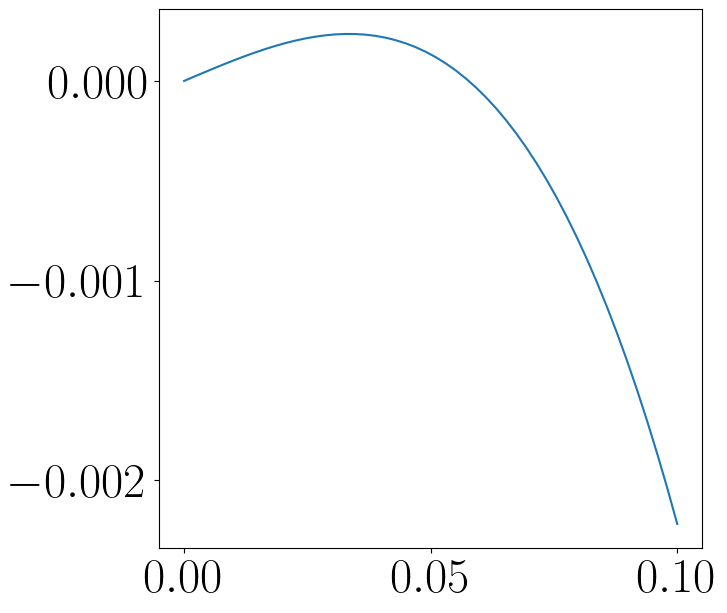

In [31]:

#  d_S =  0.2  theta_I =  0.02  H0 =  0.7586206896551724  t =  0.2  tildeGamma =  0  p_S0 =  -0.3000000000000001

S_I = S_I_bilayer(0.2, 0.0, 0)
Delta_data = np.linspace(0,0.1, num=50)
#  X, d_S, theta_I, H0, t, tildeGamma, p_S0
#FS = np.array([S_I.Sum_for_Delta_W_J([Delta], S_I.d_S, S_I.theta_I,  0.7931034482758621  , 0.2, S_I.tildeGamma, 0.3) for Delta in Delta_data])
#FS = np.array([S_I.Sum_for_Delta_W_J([Delta], S_I.d_S, S_I.theta_I,  0.99  , 0.7, S_I.tildeGamma, 0.0) for Delta in Delta_data])

#d_S =  0.2 , theta_I =  0.02 , tildeGamma =  0 , p_S0 =  -0.2900000000000001 , H0 =  0.7931034482758621 , t =  0.2 
#  d_S =  0.2  theta_I =  0.02  H0 =  0.896551724137931  t =  0.2  tildeGamma =  0  p_S0 =  -0.24000000000000007
#  d_S =  0.2  theta_I =  0.02  H0 =  0.0  t =  0.2  tildeGamma =  0  p_S0 =  0.49000000000000027
#  d_S =  0.2  theta_I =  0.02  H0 =  0.0  t =  0.2  tildeGamma =  0  p_S0 =  0.49000000000000027
# > d_S =  0.2  theta_I =  0.02  H0 =  0.0  t =  0.2  tildeGamma =  0  p_S0 =  0.45000000000000023
#  d_S =  0.2  theta_I =  0.02  H0 =  0.1724137931034483  t =  0.2  tildeGamma =  0  p_S0 =  0.5100000000000002
# d_S =  0.2  theta_I =  0.02  H0 =  0.06896551724137931  t =  0.2  tildeGamma =  0  p_S0 =  0.5100000000000002
# d_S =  0.2  theta_I =  0.02  H0 =  0.7586206896551724  t =  0.2  tildeGamma =  0  p_S0 =  -0.2800000000000001 
# d_S =  0.2  theta_I =  0.02  H0 =  0.7586206896551724  t =  0.2  tildeGamma =  0  p_S0 =  -0.2900000000000001
# d_S =  0.2  theta_I =  0.02  H0 =  0.7241379310344828  t =  0.2  tildeGamma =  0  p_S0 =  -0.3200000000000001 
# d_S =  0.2  theta_I =  0.0  H0 =  0.8163265306122448  t =  0.02  tildeGamma =  0.0  p_S0 =  0.0
FS = np.array([S_I.Sum_for_Delta_W_J([Delta], S_I.d_S, S_I.theta_I,   0.8163265306122448 , 0.02, S_I.tildeGamma,  0 ) for Delta in Delta_data])

plt.plot(Delta_data, FS)

print(S_I.Sum_for_Delta_W_J([2.64276220e-07], S_I.d_S, S_I.theta_I, 0.06896551724137931 , 0.2, S_I.tildeGamma, 0.5100000000000002))
print(S_I.Sum_for_Delta_W_J([4.50316265e-07], S_I.d_S, S_I.theta_I, 0.06896551724137931 , 0.2, S_I.tildeGamma, 0.5100000000000002))
#plt.hlines([0, np.sqrt(3.1978965979842783e-06)], xmin=0, xmax=Delta_data[-1], linestyle="--", color="red")
#plt.vlines([0.4189652802170213], ymin=0, ymax=0.05, linestyle="--", color="red")
#plt.hlines(0, xmin=0, xmax=0.5, linestyle="--", color="red")
#plt.vlines([0.11102552, 0.19423131], ymin=0, ymax=0.1, linestyle="--", color="red")

In [385]:
np.isclose([2.64276220e-07], 0.)

array([False])

In [219]:
S_I.Sum_for_Delta_W_J([0.53702309], S_I.d_S, S_I.theta_I, 0.896551724137931  , 0.2, S_I.tildeGamma,  -0.124000000000000007)

0.0

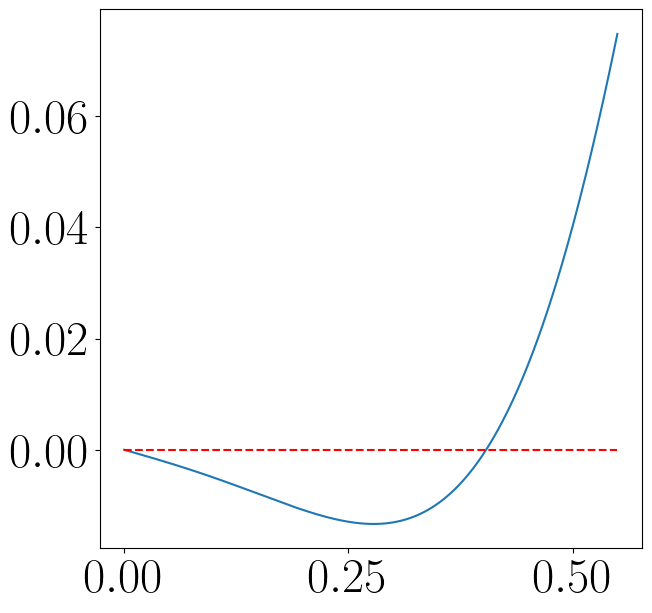

In [79]:
c = S_I_bilayer(0.2, 0.02, 0)
Delta_data = np.linspace(0, 0.55, num=500)
FS = np.array([c.Sum_for_Delta_W_J([Delta], c.d_S, c.theta_I,  0.7 , 0.2, c.tildeGamma, -0.3) for Delta in Delta_data])

plt.plot(Delta_data, FS)
#plt.hlines([0, np.sqrt(3.1978965979842783e-06)], xmin=0, xmax=Delta_data[-1], linestyle="--", color="red")
#plt.vlines([0.4189652802170213], ymin=0, ymax=0.05, linestyle="--", color="red")
plt.hlines(0, xmin=0, xmax=0.55, linestyle="--", color="red")

In [377]:
FS

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [237]:
def keep_first_occurrences(arr, tol=1e-9):
    seen = []
    result = []
    for val in arr:
        # Check if value is close to any already seen values
        if not any(np.isclose(val, seen_val, atol=tol) for seen_val in seen):
            result.append(val)
            seen.append(val)
    return np.array(result)

In [241]:
keep_first_occurrences([0.000000001, 0.0, 0.1])

array([1.e-09, 1.e-01])

In [67]:
c = S_I_bilayer(0.2, 0., 0.)
# Get_state_root(self, d_S, theta_I, tildeGamma, p_S0, H0, t, Delta0=0., tildeW0=0., tildeJ0=0.):

H_data = np.linspace(0.5*c.Get_Delta_s_In_pi_Tc(0.2)/A_H - 0.1, 0.5*c.Get_Delta_s_In_pi_Tc(0.2)/A_H + 0.1, num=150)
Delta_data = np.array([])
for h1 in H_data:
    Delta, tildeW, tildeJ = c.Get_state_root(0.2, 0., 0., 0., h1, 0.02)
    Delta_data = np.append(Delta_data, Delta)



----> d_S =  0.2  theta_I =  0.0  H0 =  0.8077824782832357  t =  0.02  tildeGamma =  0.0  p_S0 =  0.0
----> solutions =  [0.00143923 0.00176408 0.55955708] 



UnboundLocalError: cannot access local variable 'Delta' where it is not associated with a value

In [23]:
 c.Get_state_root(0.2, 0., 0., 0., 0.8163265306122448, 0.02)

----> d_S =  0.2  theta_I =  0.0  H0 =  0.8163265306122448  t =  0.02  tildeGamma =  0.0  p_S0 =  0.0
----> solutions =  [0.0577205  0.55951929] 



UnboundLocalError: cannot access local variable 'Delta' where it is not associated with a value

In [63]:
H_data

array([0.70711134, 0.71119297, 0.7152746 , 0.71935624, 0.72343787,
       0.7275195 , 0.73160113, 0.73568277, 0.7397644 , 0.74384603,
       0.74792766, 0.7520093 , 0.75609093, 0.76017256, 0.76425419,
       0.76833583, 0.77241746, 0.77649909, 0.78058073, 0.78466236,
       0.78874399, 0.79282562, 0.79690726, 0.80098889, 0.80507052,
       0.80915215, 0.81323379, 0.81731542, 0.82139705, 0.82547868,
       0.82956032, 0.83364195, 0.83772358, 0.84180521, 0.84588685,
       0.84996848, 0.85405011, 0.85813175, 0.86221338, 0.86629501,
       0.87037664, 0.87445828, 0.87853991, 0.88262154, 0.88670317,
       0.89078481, 0.89486644, 0.89894807, 0.9030297 , 0.90711134])

In [69]:
0.8077824782832357*A_H/c.Get_Delta_s_In_pi_Tc(0.2)

np.float64(0.5004157672606894)

In [71]:
 H_data*A_H/c.Get_Delta_s_In_pi_Tc(0.2)

array([0.43805068, 0.43888221, 0.43971375, 0.44054528, 0.44137682,
       0.44220835, 0.44303989, 0.44387142, 0.44470295, 0.44553449,
       0.44636602, 0.44719756, 0.44802909, 0.44886063, 0.44969216,
       0.4505237 , 0.45135523, 0.45218677, 0.4530183 , 0.45384983,
       0.45468137, 0.4555129 , 0.45634444, 0.45717597, 0.45800751,
       0.45883904, 0.45967058, 0.46050211, 0.46133364, 0.46216518,
       0.46299671, 0.46382825, 0.46465978, 0.46549132, 0.46632285,
       0.46715439, 0.46798592, 0.46881746, 0.46964899, 0.47048052,
       0.47131206, 0.47214359, 0.47297513, 0.47380666, 0.4746382 ,
       0.47546973, 0.47630127, 0.4771328 , 0.47796434, 0.47879587,
       0.4796274 , 0.48045894, 0.48129047, 0.48212201, 0.48295354,
       0.48378508, 0.48461661, 0.48544815, 0.48627968, 0.48711121,
       0.48794275, 0.48877428, 0.48960582, 0.49043735, 0.49126889,
       0.49210042, 0.49293196, 0.49376349, 0.49459503, 0.49542656,
       0.49625809, 0.49708963, 0.49792116, 0.4987527 , 0.49958

In [61]:
np.where( np.isclose(H_data, 0.8163265306122448))

(array([], dtype=int64),)

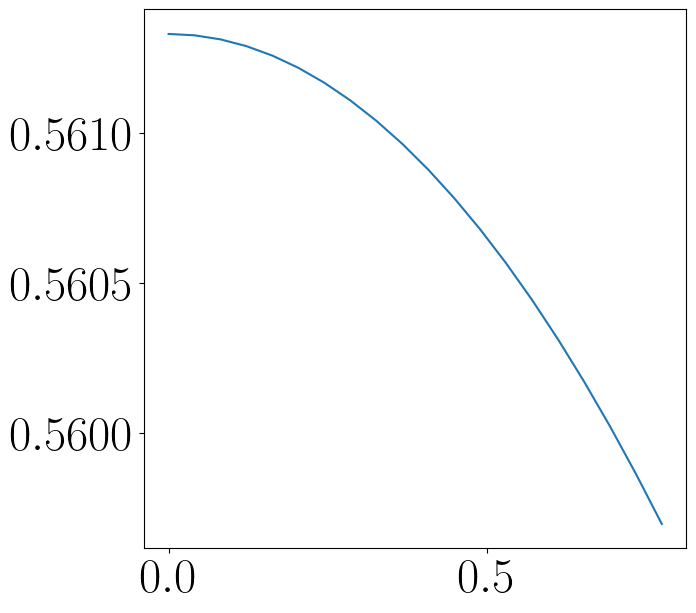

In [15]:
plt.plot(H_data[0:len(Delta_data)], Delta_data)

In [47]:
H_data[0:len(Delta_data)][-1]*A_H/c.Get_Delta_s_In_pi_Tc(0.02)

np.float64(0.48036410586575884)

In [43]:
Delta_data

array([0.56133159, 0.56132706, 0.56131349, 0.56129087, 0.5612592 ,
       0.56121848, 0.56116871, 0.56110988, 0.56104199, 0.56096504,
       0.56087903, 0.56078395, 0.56067979, 0.56056656, 0.56044425,
       0.56031285, 0.56017235, 0.56002276, 0.55986405, 0.55969623])